# Testing altair for CC9

In [62]:
import pandas as pd
import requests
import io
import altair as alt
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

### Data Wrangling

In [3]:
#read cc9_health_cities_bra.csv
db_health_cities = pd.read_csv('PortfolioData/cc9_health_cities_bra.csv')

In [4]:
columns_to_convert = ['n_med', 'tx_med', 'n_obitos_csap', 'desp_tot_saude_pc_mun', 'pop', 'tx_mort_csap']

# Replace commas with dots and convert to numeric
db_health_cities[columns_to_convert] = db_health_cities[columns_to_convert].apply(lambda x: pd.to_numeric(x.str.replace(',', '.'), errors='coerce'))

#is there na values?
db_health_cities.isna().sum()

codmun                   0
nomemun                  0
n_med                    0
tx_med                   0
n_obitos_csap            0
desp_tot_saude_pc_mun    4
pop                      0
tx_mort_csap             0
dtype: int64

In [5]:
# Sort dataset by population in descending order
db_health_cities = db_health_cities.sort_values(by='pop', ascending=False).reset_index(drop=True)

# Keep only the top 5000 rows
db_health_cities = db_health_cities.head(5000)

# Verify the change
print(db_health_cities.shape)  # Should print (5000, N) where N is the number of columns
print(db_health_cities.head())


(5000, 8)
   codmun         nomemun    n_med    tx_med  n_obitos_csap  \
0  355030       São Paulo  69126.0  6.036151        17928.0   
1  330455  Rio de Janeiro  31510.0  5.073075        15982.0   
2  530010        Brasília  13335.0  4.733119         3141.0   
3  230440       Fortaleza  10057.0  4.140885         3271.0   
4  292740        Salvador  12977.0  5.367547         4240.0   

   desp_tot_saude_pc_mun         pop  tx_mort_csap  
0                1639.41  11451999.0    156.549088  
1                1084.24   6211223.0    257.308424  
2                    NaN   2817381.0    111.486519  
3                1199.32   2428708.0    134.680661  
4                 859.81   2417678.0    175.374884  


In [8]:
#save db_health_cities as csv
db_health_cities.to_csv('PortfolioData/db_health_cities.csv', index=False)

### Ploting and reading from github

In [60]:
# URL of the CSV file
url = 'https://raw.githubusercontent.com/yantoniassi1/yantoniassi1.github.io/main/PortfolioData/cc9_health_cities_brazil.csv'

# Fetch the CSV content
response = requests.get(url, verify=False)
response.raise_for_status()  # Ensure we notice bad responses

# Read the CSV content into a pandas DataFrame
db_health_cities = pd.read_csv(io.StringIO(response.text))

# Display a sample of the data
db_health_cities.sample(5)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'raw.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,codmun,nomemun,n_med,tx_med,n_obitos_csap,desp_tot_saude_pc_mun,pop,tx_mort_csap,pop_category
1339,290670,Cândido Sales,24.0,0.950608,72.0,890.38,25247.0,285.182398,Less than 500K
318,410430,Campo Mourão,488.0,4.907877,213.0,2001.31,99432.0,214.216751,Less than 500K
4908,314920,Pedrinópolis,9.0,2.691388,7.0,2590.98,3344.0,209.330144,Less than 500K
3017,220430,Fronteiras,9.0,0.877278,14.0,1127.32,10259.0,136.465542,Less than 500K
3151,412520,São Jorge d'Oeste,18.0,1.919386,25.0,2591.04,9378.0,266.581361,Less than 500K


In [24]:
# URL to fetch the dataset from GitHub
data_url = 'https://raw.githubusercontent.com/yantoniassi1/yantoniassi1.github.io/main/PortfolioData/cc9_health_cities_brazil.csv'

# Regression Line Calculation
regression_model = np.polyfit(
    db_health_cities['tx_mort_csap'],
    db_health_cities['desp_tot_saude_pc_mun'], 
    1
)
regression_line = np.poly1d(regression_model)

# Create regression line data
regression_df = pd.DataFrame({
    'tx_mort_csap': np.linspace(
        db_health_cities['tx_mort_csap'].min(),
        db_health_cities['tx_mort_csap'].max(),
        100
    )
})
regression_df['desp_tot_saude_pc_mun'] = regression_line(regression_df['tx_mort_csap'])

# Bubble Plot with GitHub Data Source
bubble_plot = (
    alt.Chart(alt.Data(url=data_url, format=alt.DataFormat(type='csv')))
    .mark_circle(opacity=0.6)
    .encode(
        x=alt.X('tx_mort_csap:Q', title='Number of Deaths (Primary Care-Sensitive)'),
        y=alt.Y('desp_tot_saude_pc_mun:Q', title='Health Expenditure (R$ per Capita)'),
        size=alt.Size(
            'pop:Q',
            scale=alt.Scale(range=[10, 1000]),  # Adjust bubble sizes
            legend=None  # Remove the Population legend
        ),
        color=alt.Color(
            'pop_category:N',
            title='Population Range',
            scale=alt.Scale(
                domain=['Less than 500K', '500K–1M', '1M–5M', '5M+'],
                range=['#48cae4', '#ff7f0e', '#d62728', '#6f2dbd']
            )
        ),
        order=alt.Order(
            'pop:Q',
            sort='ascending'
        ),
        tooltip=[
            alt.Tooltip('nomemun:N', title='Municipality'),
            alt.Tooltip('tx_mort_csap:Q', title='Deaths (Primary Care-Sensitive)'),
            alt.Tooltip('desp_tot_saude_pc_mun:Q', title='Health Expenditure (R$)'),
            alt.Tooltip('pop:Q', title='Population'),
            alt.Tooltip('pop_category:N', title='Population Range')
        ]
    )
    .properties(
        title='Relationship Between Primary Care-Sensitive Deaths and Municipal Health Expenditure',
        width=600,
        height=400
    )
    .interactive()
)

# Regression Line Plot
regression_plot = (
    alt.Chart(regression_df)
    .mark_line(color='black', strokeDash=[5, 5])
    .encode(
        x=alt.X('tx_mort_csap:Q', title='Number of Deaths (Primary Care-Sensitive)'),
        y=alt.Y('desp_tot_saude_pc_mun:Q', title='Health Expenditure (R$ per Capita)')
    )
)

# Combine Bubble Plot and Regression Line
final_plot = bubble_plot + regression_plot
final_plot

alt.LayerChart(...)

In [25]:
# Export to JSON with GitHub Data Source
final_plot.save('cc9_bubbleplot.json')
print("✅ Bubble plot successfully exported as 'bubble_plot_with_github_source.json' with GitHub data source.")

✅ Bubble plot successfully exported as 'bubble_plot_with_github_source.json' with GitHub data source.


## Distribution

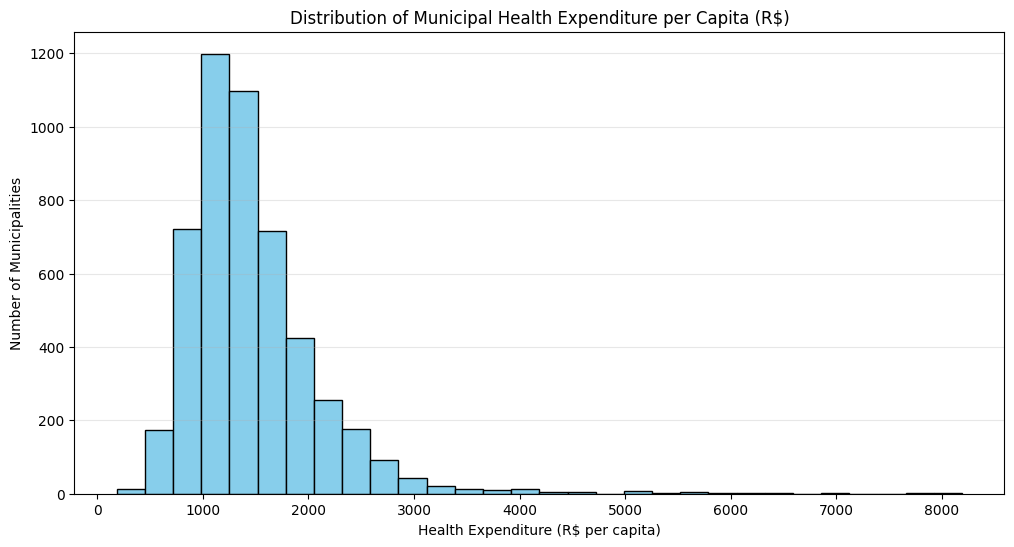

In [63]:
# Plot histogram for Health Expenditure per Capita
plt.figure(figsize=(12, 6))
plt.hist(db_health_cities['desp_tot_saude_pc_mun'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Municipal Health Expenditure per Capita (R$)')
plt.xlabel('Health Expenditure (R$ per capita)')
plt.ylabel('Number of Municipalities')
plt.grid(axis='y', alpha=0.3)
plt.show()